# The Annotated Transformer 보다 친절한 트랜스포머 튜토리얼

## 0. 데이터 가공
- 먼저, 튜토리얼에 사용하기 위해 [**AI Hub**](http://www.aihub.or.kr/)에서 [**한국어-영어 번역 말뭉치**](http://www.aihub.or.kr/aidata/87) 데이터 다운로드를 요청합니다.
- 다운로드 요청 후, 약 **2일** 내에 승인 결과가 메일로 전달된다고 합니다.
- 말뭉치는 기본적으로 **엑셀 파일**로 제공되지만, 실험의 편의를 위해 **CSV** 파일로 변환해 사용하도록 합니다.

_cf. 현재 AI Hub에서는 다양한 한영 번역 데이터셋을 구축해 총 **160만 쌍**의 데이터를 제공해주고 있지만, 모든 문장을 훈련시키기에는 데이터가 과도하므로 본 튜토리얼에서는 **구어체 데이터 1 & 2**만을 사용하도록 합니다._

In [ ]:
# 두 개 코퍼스 파일 CSV 포맷으로 변환 저장

import pandas as pd

xls_a = pd.read_excel('data/spoken1.xlsx', index_col=None)
xls_b = pd.read_excel('data/spoken2.xlsx', index_col=None)

xls_a.to_csv('data/spoken1.csv', encoding='utf-8', index=False)
xls_b.to_csv('data/spoken2.csv', encoding='utf-8', index=False)

- 이제, **CSV**로 변환한 말뭉치 파일을 `pandas` 라이브러리를 이용해 읽어옵니다.
- 읽어온 파일의 각 행을 돌며, **한국어 문장**과 **영어 문장**을 각각의 리스트에 저장해줍니다.

In [1]:
# CSV로 변환한 말뭉치 파일 로드 및 합병

data_a = pd.read_csv('data/spoken1.csv', encoding='utf-8')
data_b = pd.read_csv('data/spoken2.csv', encoding='utf-8')

data = pd.concat([data_b, data_a], ignore_index=True)

In [2]:
# 합병된 데이터 프레임 확인

data

,SID,원문,번역문
0,200001,0 설정을 입력하고 안정될 때까지 5분 동안 기다린 후 OK 버튼을 길게 누르십시오.,"Enter into 0 setting, and wait for 5 minutes t..."
1,200002,0은 그들에게 아무것도 아니었지만 무는 숫자일 수가 없습니다.,The zero was nothing for them but nothing coul...
2,200003,"1,015버전에서 핫키 버그가 있습니다.","There is a Hotkey bug in the 1,015 version."
3,200004,"1,390점에서 1,440점을 득점한 사람은 재판을 위해 걸러집니다.","Individuals who got a score between 1,390 and ..."
4,200005,"1,400년보다 오래 전의 유적지에 있는 최초의 성당에서 숭배자들은 그것을 인지했을...","Indeed, worshippers at the very first cathedra..."
...,...,...,...
399995,199996,나는 먼저 청소기로 바닥을 밀었어요.,"First of all, I vacuumed the floor."
399996,199997,나는 먼저 팀 과제를 하고 놀러 갔어요.,I did the team assignment first and went out t...
399997,199998,나는 비 같은 멋진 연예인을 좋아해요.,I like cool entertainer like Rain.
399998,199999,나는 멋진 자연 경치를 보고 눈물을 흘렸어.,I cried seeing the amazing scenery.


- 두 코퍼스를 병합해 총 **400,000개**의 **병렬 문장 쌍**이 만들어진 것을 확인하였습니다!
- 이제 해당 데이터 프레임을 돌며, 한국어 문장과 영어 문장을 리스트에 각각 저장해줍니다.

In [4]:
# 한국어, 영어 데이터를 별개 리스트에 저장

kor_lines = []
eng_lines = []

for _, row in data.iterrows():
    _, kor, eng = row
    kor_lines.append(kor)
    eng_lines.append(eng)

**언어별 데이터**가 잘 저장되었는지 일부 데이터를 출력해 확인합니다.

In [5]:
for kor, eng in zip(kor_lines[:5], eng_lines[:5]):
    print(f'[KOR]: {kor}')
    print(f'[ENG]: {eng}\n')

[KOR]: 0 설정을 입력하고 안정될 때까지 5분 동안 기다린 후 OK 버튼을 길게 누르십시오.
[ENG]: Enter into 0 setting, and wait for 5 minutes to make it stable, then long-press OK button.

[KOR]: 0은 그들에게 아무것도 아니었지만 무는 숫자일 수가 없습니다.
[ENG]: The zero was nothing for them but nothing couldn't be a number.

[KOR]: 1,015버전에서 핫키 버그가 있습니다.
[ENG]: There is a Hotkey bug in the 1,015 version.

[KOR]: 1,390점에서 1,440점을 득점한 사람은 재판을 위해 걸러집니다.
[ENG]: Individuals who got a score between 1,390 and 1,440 are selected for a judge.

[KOR]: 1,400년보다 오래 전의 유적지에 있는 최초의 성당에서 숭배자들은 그것을 인지했을 것입니다.
[ENG]: Indeed, worshippers at the very first cathedral on this site, over 1,400 years ago, would have still recognized it.



**Tokenizers** 라이브러리를 학습시키기 위한 **훈련용 텍스트 파일**을 만들어줍니다.

In [6]:
# 한국어 토크나이저 훈련 데이터 제작

with open('train_korean.txt', 'w', encoding='utf-8') as f:
    for line in kor_lines:
        print(line, file=f)


# 영어 토크나이저 훈련 데이터 제작

with open('train_english.txt', 'w', encoding='utf-8') as f:
    for line in eng_lines:
        print(line, file=f)

## 1. BPE 토크나이저 학습
- 앞서 가공한 데이터들을 활용해 **BPE 토크나이저**를 학습시킵니다.
- 토크나이저를 학습시키기 앞서 프로젝트 전반에 사용될 변수 사전을 정의합니다.

In [7]:
params = {
    'batch_size': 64,
    'num_epoch': 15,
    'dropout': 0.1,
    'min_frequency': 3,
    
    'vocab_size': 20000,
    'num_layers': 6,
    'num_heads': 8,
    'hidden_dim': 512,
    'ffn_dim': 2048,
}

- 한국어와 영어 토크나이저를 **별도로 초기화해 훈련**시킵니다.

In [8]:
from tokenizers import BPETokenizer

# 한국어 토크나이저 초기화

kor_tokenizer = BPETokenizer()


# 한국어 토크나이저 훈련

kor_tokenizer.train(
    ['train_korean.txt'],
    vocab_size=params['vocab_size'],
    min_frequency=params['min_frequency'],
    special_tokens=['[PAD]', '[SOS]', '[EOS]', '[UNK]'],
    suffix=''
)

In [9]:
# 영어 토크나이저 초기화

eng_tokenizer = BPETokenizer()


# 영어 토크나이저 훈련

eng_tokenizer.train(
    ['train_english.txt'],
    vocab_size=params['vocab_size'],
    min_frequency=params['min_frequency'],
    special_tokens=['[PAD]', '[SOS]', '[EOS]', '[UNK]'],
    suffix=''
)

**패딩 옵션**과 **후처리 작업** 등에 사용될 **스페셜 토큰**들의 아이디를 저장해줍니다.

In [10]:
pad_idx = kor_tokenizer.token_to_id('[PAD]')
sos_idx = kor_tokenizer.token_to_id('[SOS]')
eos_idx = kor_tokenizer.token_to_id('[EOS]')

## 2. 훈련된 토크나이저로 토큰화 진행

Tokenizers의 `encode_batch` 함수를 활용해 각 데이터들에 대해 **토큰화 작업을 수행**해줍니다.

In [11]:
kor_encoded_data = kor_tokenizer.encode_batch(kor_lines)
eng_encoded_data = eng_tokenizer.encode_batch(eng_lines)

토큰화 작업이 잘 수행되었는지 기존 데이터와 비교해 확인합니다.

In [12]:
# 한국어 데이터 토큰화 작업 결과 출력

for origin, processed in zip(kor_lines[:3], kor_encoded_data[:3]):
    print(f'[Orig]: {origin}')
    print(f'[Proc]: {processed.tokens}\n')

[Orig]: 0 설정을 입력하고 안정될 때까지 5분 동안 기다린 후 OK 버튼을 길게 누르십시오.
[Proc]: ['0', '설', '정을', '입력', '하고', '안정', '될', '때까지', '5분', '동안', '기다', '린', '후', 'ok', '버튼을', '길게', '누르', '십시오', '.']

[Orig]: 0은 그들에게 아무것도 아니었지만 무는 숫자일 수가 없습니다.
[Proc]: ['0', '은', '그들에게', '아무것도', '아니', '었지만', '무', '는', '숫자', '일', '수가', '없습니다', '.']

[Orig]: 1,015버전에서 핫키 버그가 있습니다.
[Proc]: ['1', ',', '0', '15', '버전', '에서', '키', '버', '그가', '있습니다', '.']



In [13]:
# 영어 데이터 토큰화 작업 결과 출력

for origin, processed in zip(eng_lines[:3], eng_encoded_data[:3]):
    print(f'[Orig]: {origin}')
    print(f'[Proc]: {processed.tokens}\n')

[Orig]: Enter into 0 setting, and wait for 5 minutes to make it stable, then long-press OK button.
[Proc]: ['enter', 'into', '0', 'setting', ',', 'and', 'wait', 'for', '5', 'minutes', 'to', 'make', 'it', 'stable', ',', 'then', 'long', '-', 'press', 'ok', 'button', '.']

[Orig]: The zero was nothing for them but nothing couldn't be a number.
[Proc]: ['the', 'zero', 'was', 'nothing', 'for', 'them', 'but', 'nothing', 'couldn', "'", 't', 'be', 'a', 'number', '.']

[Orig]: There is a Hotkey bug in the 1,015 version.
[Proc]: ['there', 'is', 'a', 'hot', 'key', 'bug', 'in', 'the', '1', ',', '0', '15', 'version', '.']



## 3. 토큰화 결과에 후처리 로직 적용

- 이제 토큰화 작업이 수행된 결과에 **[PAD]** 토큰을 붙여줄 차례입니다.
- **[PAD]** 토큰은 모델이 입력으로 받는 **최대 길이** 보다 길이가 짧은 문장들에 한해 부여되는 토큰이므로, 
- **최대 길이**로 설정할 적정 길이를 찾기 위해 각 언어 쌍의 평균 길이와 최대 길이를 계산합니다.

In [169]:
# 한국어 데이터 평균 및 최대 길이 계산

kor_len_max = max(len(line.tokens) for line in kor_encoded_data)
kor_len = 0

for line in kor_encoded_data:
    kor_len += len(line.tokens)
kor_len_avg = kor_len / len(kor_encoded_data)

kor_len_avg, kor_len_max

(11.27639, 49)

In [170]:
# 영어 데이터 평균 및 최대 길이 계산

eng_len_max = max(len(line.tokens) for line in eng_encoded_data)
eng_len = 0

for line in eng_encoded_data:
    eng_len += len(line.tokens)
eng_len_avg = eng_len / len(eng_encoded_data)

eng_len_avg, eng_len_max

(12.8836825, 65)

데이터셋 내 문장들이 그렇게 긴 편이 아니므로 **32**로 입력 값의 **최대 길이**로 정해줍니다.

In [18]:
params['max_len'] = 32

마지막으로 **[PAD]** 토큰을 붙여주는 `pad_sentence` 함수와 

문장의 시작과 끝을 알리는 **[SOS]**, **[EOS]** 토큰을 붙여주는 후처리 함수 `postprocess`를 정의해줍니다.

In [24]:
def pad_sentence(input_ids):
    '''최대 길이보다 짧은 문장들에 [PAD] 토큰 부여'''

    num_pad = params['max_len'] - len(input_ids)
    input_ids.extend([pad_idx] * num_pad)
    return input_ids

In [27]:
def postprocess(input_ids):
    '''입력 문장에 [SOS] 토큰과 [EOS] 토큰 부여'''
    
    input_ids = pad_sentence(input_ids)
    
    input_ids = [sos_idx] + input_ids
    
    input_ids = input_ids[:params['max_len']]

    if pad_idx in input_ids:
        pad_start = input_ids.index(pad_idx)
        input_ids[pad_start] = eos_idx
    else:
        input_ids[-1] = eos_idx
    
    return input_ids

앞서 정의한 두 함수를 이용하면 결과 값이 다음과 같이 바뀝니다.

In [176]:
# 기본 토큰화 작업 결과 

sent = '우리 진짜 별나대 그냥 내가 너무 좋아해 넌 그걸 너무 잘 알고 날 쥐락펴락해 나도 마찬가지인걸'

proc_sent = kor_tokenizer.encode(sent)
print(f'토큰화 결과: {proc_sent.tokens}')

토큰화 결과: ['우리', '진짜', '별', '나', '대', '그냥', '내가', '너무', '좋아해', '넌', '그걸', '너무', '잘', '알고', '날', '쥐', '락', '펴', '락', '해', '나도', '마찬가지', '인', '걸']


In [178]:
# 토큰화 + 후처리 작업 결과

post_proc_sent = postprocess(proc_sent.ids)

print(f'후처리 결과: {post_proc_sent}\n')
print(f'후처리 해석: {kor_tokenizer.decode(post_proc_sent)}')

후처리 결과: [1, 1096, 3879, 472, 173, 249, 2811, 1190, 1393, 7045, 196, 4602, 1393, 717, 1833, 177, 758, 316, 917, 316, 950, 2186, 7015, 703, 78, 2, 0, 0, 0, 0, 0, 0]

후처리 해석: [SOS]우리진짜별나대그냥내가너무좋아해넌그걸너무잘알고날쥐락펴락해나도마찬가지인걸[EOS][PAD][PAD][PAD][PAD][PAD][PAD]


이제 후처리 함수를 활용해 모든 데이터셋들에 대해 **후처리 작업을 진행**해줍니다.

In [28]:
kor_processed_data = [postprocess(data.ids) for data in kor_encoded_data]
eng_processed_data = [postprocess(data.ids) for data in eng_encoded_data]

## 4. 모든 데이터셋을 텐서형 데이터로 변환

- 전처리와 후처리를 모두 마친 데이터들을 `torch.Tensor`로 변환해줍니다.
- 변환 후, `DataLoader`를 활용해 데이터들을 **배치**로 만들어줍니다.

In [38]:
import torch

torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kor_tensors = [torch.LongTensor(line).to(device) for line in kor_processed_data]
eng_tensors = [torch.LongTensor(line).to(device) for line in eng_processed_data]

src_iter = data.DataLoader(kor_tensors, batch_size=params['batch_size'])
tgt_iter = data.DataLoader(eng_tensors, batch_size=params['batch_size'])

배치 데이터가 잘 생성되었는지 출력을 통해 확인합니다.

## 5. Transformer 모델링

- 먼저 모델 구현에 필요한 라이브러리들을 모두 임포트합니다.
- 실험을 함에 있어 항상 실험의 **Reproducibility**를 보장하기 위해 Seed 설정을 해줍니다.

In [57]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(32)
torch.cuda.manual_seed(32)
torch.backends.cudnn.deterministic = True

## 5-1. (Masked) Multi-Head Attention 구현

## 2.1 Sub Layers
### Multi-Head Attention

![](img/mha.png)

In [91]:
class MultiHeadAttention(nn.Module):
    '''멀티 헤드 어텐션 레이어'''
    def __init__(self, params):
        super(MultiHeadAttention, self).__init__()
        assert params['hidden_dim'] % params['num_heads'] == 0, "hidden dimension must be divisible by the number of heads"
        self.num_heads = params['num_heads']
        self.attn_dim = params['hidden_dim'] // self.num_heads
        
        self.q_w = nn.Linear(params['hidden_dim'], self.num_heads * self.attn_dim)
        self.k_w = nn.Linear(params['hidden_dim'], self.num_heads * self.attn_dim)
        self.v_w = nn.Linear(params['hidden_dim'], self.num_heads * self.attn_dim)
        
        self.o_w = nn.Linear(self.num_heads * self.attn_dim, params['hidden_dim'])
        
    def forward(self, q, k, v, mask=None):
        " q, k, v = [배치 사이즈, 문장 길이, 은닉 차원] "
        
        batch_size = q.size(0)
        
        q = self.q_w(q).view(batch_size, -1, self.num_heads, self.attn_dim).transpose(1, 2)
        k = self.k_w(k).view(batch_size, -1, self.num_heads, self.attn_dim).transpose(1, 2)
        v = self.v_w(v).view(batch_size, -1, self.num_heads, self.attn_dim).transpose(1, 2)
        # q, k, v = [배치 사이즈, 헤드 갯수, 문장 길이, 어텐션 차원]
        
        attn = torch.matmul(q, k.transpose(-1, -2))
        # attn = [배치 사이즈, 헤드 갯수, 문장 길이, 문장 길이]
        
        if mask is not None:
            mask = mask.unsqueeze(1)
            attn.masked_fill(mask==0, -1e9)
        
        score = F.softmax(attn, dim=-1)
        # score = [배치 사이즈, 헤드 갯수, 문장 길이, 문장 길이]
        
        output = torch.matmul(score, v)
        # output = [배치 사이즈, 헤드 갯수, 문장 길이, 어텐션 차원]
        
        output = output.transpose(1, 2).contiguous()
        # output = [배치 사이즈, 문장 길이, 헤드 갯수, 어텐션 차원]
        
        output = output.view(batch_size, -1, self.num_heads * self.attn_dim)
        # output = [배치 사이즈, 문장 길이, 은닉 차원]
        
        output = self.o_w(output)
        # output = [배치 사이즈, 문장 길이, 은닉 차원]
        
        return output, score

Masked Multi Head Attention을 위한 Subsequent Mask를 생성해주어야 합니다.

In [136]:
def create_subsequent_mask(tgt):
    batch_size, tgt_len = tgt.size()
    
    subsequent_mask = torch.triu(torch.ones(tgt_len, tgt_len), diagonal=1).bool()
    # subsequent_mask = [타겟 문장 길이, 타겟 문장 길이]
    
    subsequent_mask = subsequent_mask.unsqueeze(0).repeat(batch_size, 1, 1).to(device)
    # subsquent_mask = [배치 사이즈, 타겟 문장 길이, 타겟 문장 길이]
    
    return subsequent_mask

사용 예는 아래와 같습니다.

['왜', '들', '그리', '다운', '돼', '있어', '?', '뭐가', '문제', '야', 'say', 'something', '분위기가', '겁', '나', '싸', '해']


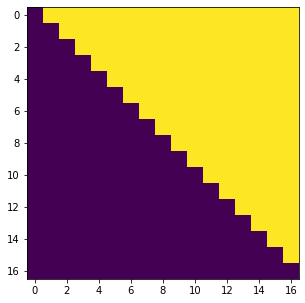

In [192]:
test_sent = '왜들 그리 다운돼있어? 뭐가 문제야 say something 분위기가 겁나 싸해'
test_tensor = kor_tokenizer.encode(test_sent)
test_tensor = torch.LongTensor(test_tensor.ids).to(device).unsqueeze(0)

plt.figure(figsize=(5,5))
plt.imshow(create_subsequent_mask(test_tensor).cpu()[0])

In [157]:
def create_src_mask(src):
    " source = [배치 사이즈, 소스 문장 길이] "

    src_len = src.size(1)
    
    src_mask = (src == pad_idx)
    # src_mask = [배치 사이즈, 소스 문장 길이]
    
    src_mask = src_mask.unsqueeze(1).repeat(1, src_len, 1)
    # src_mask = [배치 사이즈, 소스 문장 길이, 소스 문장 길이]

    return src_mask.to(device)


def create_tgt_mask(src, tgt):
    " src = [배치 사이즈, 소스 문장 길이] "
    " tgt = [배치 사이즈, 타겟 문장 길이] "
    
    batch_size, tgt_len = tgt.size()
    
    subsequent_mask = create_subsequent_mask(tgt)
    
    enc_dec_mask = (src == pad_idx)
    tgt_mask = (tgt == pad_idx)
    # src_mask = [배치 사이즈, 소스 문장 길이]
    # tgt_mask = [배치 사이즈, 타겟 문장 길이]
    
    enc_dec_mask = enc_dec_mask.unsqueeze(1).repeat(1, tgt_len, 1).to(device)
    tgt_mask = tgt_mask.unsqueeze(1).repeat(1, tgt_len, 1).to(device)
    # src_mask = [배치 사이즈, 타겟 문장 길이, 소스 문장 길이]
    # tgt_mask = [배치 사이즈, 타겟 문장 길이, 타겟 문장 길이]

    tgt_mask = tgt_mask | subsequent_mask
    
    return enc_dec_mask, tgt_mask

소스 문장의 마스크 생성 예는 아래와 같습니다.

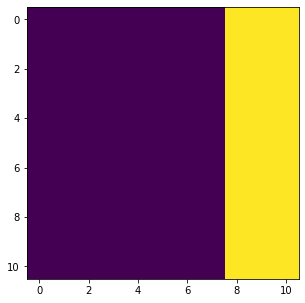

In [151]:
src = torch.tensor([[1, 2, 3, 4, 2, 11, 28, 7, 0, 0, 0]])
src_mask = create_src_mask(src)
plt.figure(figsize=(5,5))
plt.imshow(src_mask.cpu()[0])

타겟 문장의 마스크 생성 예는 아래와 같습니다.

In [160]:
tgt = torch.tensor([[1, 2, 3, 4, 2, 11, 28, 7, 99, 987, 1024, 0, 0]])
enc_dec_mask, tgt_mask = create_tgt_mask(src, tgt)

아래 그림은 타겟 문장이 소스 문장에 Attention을 취할 때 [PAD] 토큰이 마스킹 되는 예입니다.

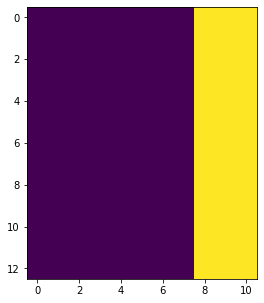

In [161]:
plt.figure(figsize=(5,5))
plt.imshow(enc_dec_mask.cpu()[0])

아래 예는 타겟 문장에서 Self-Attention 연산이 취해질 때 타임 스텝 상 뒤에 위치하는 토큰들과 [PAD] 토큰들이 마스킹 되는 예입니다.

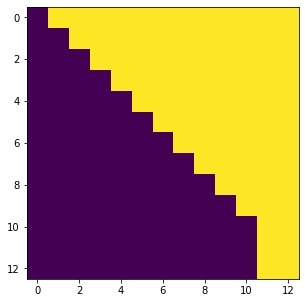

In [162]:
plt.figure(figsize=(5,5))
plt.imshow(tgt_mask.cpu()[0])

## 5-2. Position-wise Feed-Forward 네트워크 구현

![](img/positionwise.png)

In [125]:
## 5-2. Position-wise Feed-Forward 네트워크 구현class PositionwiseFeedForward(nn.Module):
    '''포지션 와이즈 피드 포워드 레이어'''
    def __init__(self, parmas):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(params['hidden_dim'], params['ffn_dim'])
        self.fc2 = nn.Linear(params['ffn_dim'], params['hidden_dim'])
        self.dropout = nn.Dropout(params['dropout'])
    
    def forward(self, x):
        " x = [배치 사이즈, 문장 길이, 은닉 차원] "

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

## 5-3. Positional Encoding 레이어 구현

![](img/pos.png)

In [126]:
class PositionalEncoding(nn.Module):
    def __init__(self, params):
        super(PositionalEncoding, self).__init__()
        sinusoid = np.array([pos / np.power(10000, 2 * i / params['hidden_dim'])
                            for pos in range(params['max_len']) for i in range(params['hidden_dim'])])
        # sinusoid = [문장 최대 길이 * 은닉 차원]

        sinusoid = sinusoid.reshape(params['max_len'], -1)
        # sinusoid = [문장 최대 길이, 은닉 차원]

        sinusoid[:, 0::2] = np.sin(sinusoid[:, 0::2])
        sinusoid[:, 1::2] = np.cos(sinusoid[:, 1::2])
        sinusoid = torch.FloatTensor(sinusoid).to(device)

        self.embedding = nn.Embedding.from_pretrained(sinusoid, freeze=True)
        
    def forward(self, x):
        " x = [배치 사이즈, 문장 길이] "
        
        pos = torch.arange(x.size(-1), dtype=torch.long).to(device)
        # pos = [배치 사이즈, 문장 길이]

        embed = self.embedding(pos)
        # embed = [배치 사이즈, 문장 길이, 은닉 차원]
        return embed

## 5-4. Transformer 인코더 부 구현

![](img/encoder.png)

In [127]:
class EncoderLayer(nn.Module):
    '''인코더 레이어'''
    def __init__(self, params):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(params)
        self.layer_norm1 = nn.LayerNorm(params['hidden_dim'])
        self.feed_forward = PositionwiseFeedForward(params)
        self.layer_norm2 = nn.LayerNorm(params['hidden_dim'])
        self.dropout = nn.Dropout(params['dropout'])
        
    def forward(self, x, src_mask):
        " x = [배치 사이즈, 문장 길이, 은닉 차원] "
        
        residual = x
        x, _ = self.self_attn(x, x, x, src_mask)
        x = self.dropout(x)
        x = residual + x
        x = self.layer_norm1(x)
        
        residual = x
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = residual + x
        x = self.layer_norm2(x)
        
        return x


class Encoder(nn.Module):
    '''트랜스포머 인코더'''
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.tok_embedding = nn.Embedding(params['vocab_size'], params['hidden_dim'], padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(params)
        self.layers = nn.ModuleList([EncoderLayer(params) for _ in range(params['num_layers'])])
        
    def forward(self, src):
        " src = [배치 사이즈, 소스 문장 길이] "

        src_mask = create_src_mask(src)
        src = self.tok_embedding(src) + self.pos_embedding(src)
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        # src = [배치 사이즈, 소스 문장 길이, 은닉 차원]
        return src

## 5-5. Transformer 인코더 부 구현

![](img/decoder.png)

In [128]:
class DecoderLayer(nn.Module):
    '''디코더 레이어'''
    def __init__(self, params):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(params)
        self.layer_norm1 = nn.LayerNorm(params['hidden_dim'])

        self.enc_dec_attn = MultiHeadAttention(params)
        self.layer_norm2 = nn.LayerNorm(params['hidden_dim'])
        
        self.feed_forward = PositionwiseFeedForward(params)
        self.layer_norm3 = nn.LayerNorm(params['hidden_dim'])
        
        self.dropout = nn.Dropout(params['dropout'])
        
    def forward(self, x, tgt_mask, enc_output, src_mask):
        " x = [배치 사이즈, 문장 길이, 은닉 차원] "
        
        residual = x
        x, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.dropout(x)
        x = residual + x
        x = self.layer_norm1(x)
        
        residual = x
        x, attn_map = self.enc_dec_attn(x, enc_output, enc_output, src_mask)
        x = self.dropout(x)
        x = residual + x
        x = self.layer_norm2(x)
        
        residual = x
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = residual + x
        x = self.layer_norm3(x)
        
        return x, attn_map


class Decoder(nn.Module):
    '''트랜스포머 디코더'''
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.tok_embedding = nn.Embedding(params['vocab_size'], params['hidden_dim'], padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(params)
        self.layers = nn.ModuleList([DecoderLayer(params) for _ in range(params['num_layers'])])
        
    def forward(self, tgt, src, enc_out):
        " tgt = [배치 사이즈, 타겟 문장 길이] "

        src_mask, tgt_mask = create_tgt_mask(src, tgt)
        tgt = self.tok_embedding(tgt) + self.pos_embedding(tgt)
        
        for layer in self.layers:
            tgt, attn_map = layer(tgt, tgt_mask, enc_out, src_mask)
            
        tgt = torch.matmul(tgt, self.tok_embedding.weight.transpose(0, 1))
        # tgt = [배치 사이즈, 타겟 문장 길이, 은닉 차원]

        return tgt, attn_map

## 5-6. Transformer 구현

이제 앞서 정의한 레이어들을 토대로 **Transformer** 모델을 빌드해줍니다.

In [129]:
class Transformer(nn.Module):
    '''트랜스포머 네트워크'''
    def __init__(self, params):
        super(Transformer, self).__init__()
        self.encoder = Encoder(params)
        self.decoder = Decoder(params)
    
    def forward(self, src, tgt):
        " src = [배치 사이즈, 소스 문장 길이] "
        " tgt = [배치 사이즈, 타겟 문장 길이] "
        
        enc_out = self.encoder(src)
        dec_out, attn = self.decoder(tgt, src, enc_out)
        return dec_out, attn
    
    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

Transformer 에서는 Adam Optimizer에 일부 스케줄 옵션을 적용해 사용하고 있습니다.

## 5-7. Transformer Optimizer 구현

![](img/optim.png)

In [182]:
class ScheduledOptim:
    '''스케줄 옵티마이저'''
    def __init__(self, optimizer, warmup_steps):
        self.init_lr = np.power(params['hidden_dim'], -0.5)
        self.optimizer = optimizer
        self.step_num = 0
        self.warmup_steps = warmup_steps
    
    def step(self):
        self.step_num += 1
        lr = self.init_lr * self.get_scale()
        
        for p in self.optimizer.param_groups:
            p['lr'] = lr
            
        self.optimizer.step()
    
    def zero_grad(self):
        self.optimizer.zero_grad()
    
    def get_scale(self):
        return np.min([
            np.power(self.step_num, -0.5),
            self.step_num * np.power(self.warmup_steps, -1.5)
        ])

## 6. 모델 학습

In [185]:
# 모델 정의

model = Transformer(params)
model.to(device)
print(f'The model has {model.count_params():,} trainable parameters')


# 로스 함수 정의

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
criterion.to(device)


# 옵티마이저 정의

optimizer = ScheduledOptim(
    optim.Adam(model.parameters(), betas=[0.9, 0.98], eps=1e-9),
    warmup_steps=4000
)


# 훈련 로직

for epoch in range(params['num_epoch']):
    model.train()
    epoch_loss = 0

    for src, tgt in zip(src_iter, tgt_iter):
        " src = [배치 사이즈, 소스 문장 길이] "
        " tgt = [배치 사이즈, 타겟 문장 길이] "
        
        optimizer.zero_grad()
        
        logits, _ = model(src, tgt[:, :-1])
        # logits = [배치 사이즈, 타겟 문장 길이, 은닉 차원]
        
        logits = logits.contiguous().view(-1, logits.size(-1))
        # logits = [(배치 사이즈 * 타겟 문장 길이) - 1, 은닉 차원]
        golds = tgt[:, 1:].contiguous().view(-1)
        # golds = [(배치 사이즈 * 타겟 문장 길이) - 1]

        loss = criterion(logits, golds)
        epoch_loss += loss.item()
        
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), self.params.clip)
        optimizer.step()

    train_loss = epoch_loss / len(self.train_iter)
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}')

The model has 64,618,496 trainable parameters


KeyboardInterrupt: 

## 7. 학습 결과 확인

이제 학습된 모델이 어느 정도 성능을 보이는지 확인해 볼 차례입니다.

In [56]:
def predict():
    model.eval()

### 참고자료
- [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
- [jadore801120/attention-is-all-you-need-pytorch](https://github.com/jadore801120/attention-is-all-you-need-pytorch)
- [tunz/transformer-pytorch](https://github.com/tunz/transformer-pytorch)
- [IgorSusmelj/pytorch-styleguide](https://github.com/IgorSusmelj/pytorch-styleguide)


### TODO: 더 추가할 수 있는 것들 !
- **Beam Search** 디코딩 추가
- **Label Smoothing** 기법 추가